In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
sns.set()

import import_ipynb
from BankFindSearch import search

In [3]:
r = search('financials', 'CALLYM:202103 AND ACTIVE:1')

In [4]:
data = pd.DataFrame(r)

In [5]:
nas = []
for col in data.columns:
    count = 0
    for num in data[col]:
        if pd.isna(num):
            count += 1
    if count > 0:
        nas.append((col, count))

In [6]:
nas_to_drop = []
for n in nas:
    if n[1] > 17:
        nas_to_drop.append(n[0])

In [7]:
new_data = data.drop(nas_to_drop + ['ID'], axis =1)

In [8]:
new_data.shape[0] - new_data.dropna().shape[0]

18

In [9]:
cdata = new_data.dropna()

In [10]:
cdataf = cdata.select_dtypes(exclude=['object', 'string'])

In [11]:
flag_cols = []
for col in cdataf.columns:
    is_binary = True
    for num in cdataf[col]:
        if not (num == 0 or num == 1):
            is_binary = False
            break
    if is_binary:
        flag_cols.append(col)

In [12]:
flags_to_drop = []
for flag in flag_cols:
    avg = sum(cdataf[flag]) / len(cdataf[flag])
    if avg == 0 or avg == 1:
        flags_to_drop.append(flag)

cdata2 = cdataf.drop(flags_to_drop, axis=1)                      

In [13]:
qxcols = []
for col in cdata2.columns:
    if col[-1] == 'X' or col[-1] == 'Q':
        qxcols.append(col)

cdata3 = cdata2.drop(qxcols, axis = 1)

In [14]:
targets = [0 if x < 1 else 1 for x in cdata3['ROA']]
sum(targets) / len(targets)

0.5890547263681593

In [15]:
cdata_shuff =  cdata3.sample(frac=1, random_state=70)
inputs = cdata_shuff.drop('ROA', axis = 1)
targets = [0 if x < 1  else 1 for x in cdata_shuff['ROA']]

In [16]:
train, test = train, test = train_test_split(inputs, test_size=0.10, shuffle=False)

train_targets = targets[:len(train)]
test_targets = targets[len(train):]

In [17]:
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

In [40]:
param = {'max_depth':3, 'eta':1, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[15:09:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

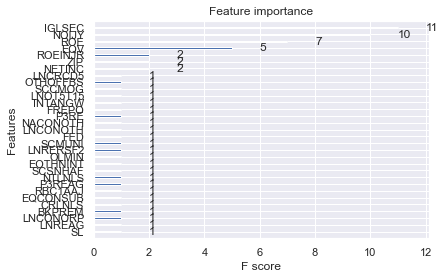

In [42]:
xgb.plot_importance(bst)

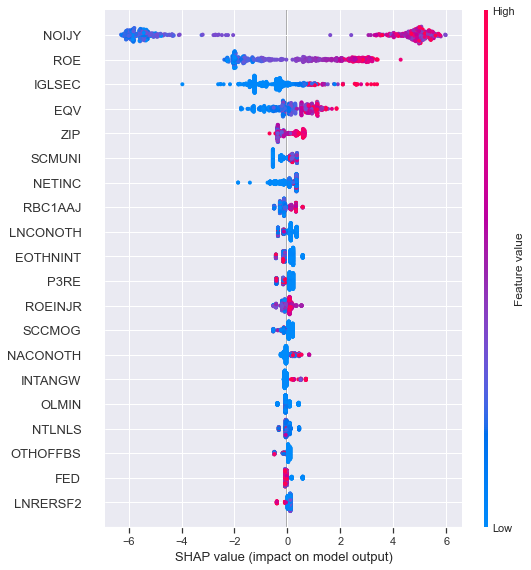

In [46]:
#print shap output - very helpful for understanding variable importance
shape_values = shap.TreeExplainer(bst).shap_values(test)
shap.summary_plot(shape_values, test)

In [43]:
train_preds = [1 if x >= .5 else 0 for x in bst.predict(dtrain)]
test_preds = [1 if x >= .5 else 0 for x in preds]
train_accuracy = accuracy_score(train_targets, train_preds)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 1.0
Test accuracy: 0.9940357852882704


In [22]:
xname = 'NETINC'
plotdata = cdata3[['ROA', xname]]
from scipy import stats
cplotdata = plotdata[(np.abs(stats.zscore(plotdata)) < 3).all(axis=1)]

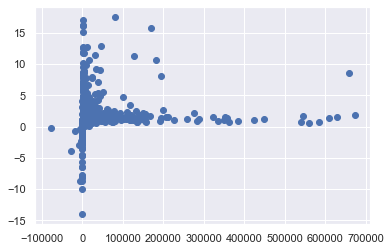

In [23]:
x = cplotdata[xname]
y = cplotdata['ROA']
plt.scatter(x,y)
plt.show()

In [24]:
sig_cols_to_drop = ['NOIJY', 'ROE', 'ROEINJR', 'NETINC', 'NETINCA', 'IBEFXTR', 'NETINBM', 'NOIJ', 'CHFLA', 'NONIIAY', 'NONII']

In [25]:
cdata4 = cdata3.drop(sig_cols_to_drop, axis = 1)
cdata_shuff2 =  cdata4.sample(frac=1, random_state=6)
inputs2 = cdata_shuff2.drop('ROA', axis = 1)
targets2 = [0 if x < 1  else 1 for x in cdata_shuff2['ROA']]

In [26]:
train2, test2 = train_test_split(inputs2, test_size=0.10, shuffle=False)

train_targets2 = targets2[:len(train2)]
test_targets2 = targets2[len(train2):]

In [27]:
dtrain2 = xgb.DMatrix(train2, label=train_targets2)
dtest2 = xgb.DMatrix(test2, label=test_targets2)

In [28]:
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 8
bst2 = xgb.train(param, dtrain2, num_round)

[15:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [29]:
preds2 = bst2.predict(dtest2)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

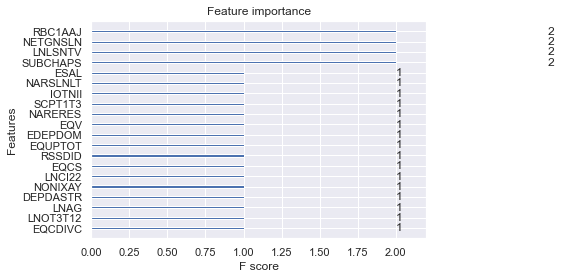

In [30]:
xgb.plot_importance(bst2)

In [31]:
train_preds = [1 if x >= .5 else 0 for x in bst2.predict(dtrain2)]
test_preds = [1 if x >= .5 else 0 for x in preds2]
train_accuracy = accuracy_score(train_targets2, train_preds)
test_accuracy = accuracy_score(test_targets2, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.7697921273772667
Test accuracy: 0.7335984095427436
